<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/4_Feature_selection_%26_data_balancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [51]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/Datasets/dataset_after_ops.csv')

In [52]:
org = pd.read_csv('/content/gdrive/MyDrive/Datascience/Datasets/dataset_after_ops.csv')

org["date"] = pd.to_datetime(org["date"])

org.insert(0,'new_date',org['date'].dt.strftime("%Y%m%d%H%M%S").astype(int))
org.drop('date', axis=1, inplace=True)

org

,new_date,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate,Purity
0,20170310010000,55.20,16.98,3163.452165,578.910104,398.770942,10.113760,1.729498,251.177960,250.208694,...,450.343243,446.972364,450.622040,449.948988,455.523590,464.487434,450.111873,66.91,1.31,1
1,20170310020000,55.20,16.98,3133.256389,537.219661,399.871822,10.129742,1.667784,249.880589,250.214050,...,449.373361,450.249356,450.081222,450.328806,448.722983,455.501528,451.387700,67.06,1.11,1
2,20170310030000,55.20,16.98,3479.482944,591.906744,398.763806,10.048403,1.732711,250.161328,250.104167,...,449.972878,450.868711,450.901822,451.145822,451.134189,459.981311,450.296722,66.97,1.27,1
3,20170310040000,55.20,16.98,3228.036436,593.170106,399.866983,9.918614,1.731056,250.208772,250.204761,...,487.940706,491.462111,487.387206,494.528183,495.664011,502.763850,494.939889,66.75,1.36,1
4,20170310050000,55.20,16.98,3327.280739,619.710806,399.615089,9.746029,1.765879,249.917800,250.160494,...,549.031539,549.983156,549.459572,549.975483,549.512533,560.696300,550.271772,66.63,1.34,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417,20170909190000,49.75,23.20,3221.735214,498.785884,384.302022,9.179293,1.660170,301.432594,299.781377,...,394.817435,497.870623,409.189681,400.281507,500.450507,400.089188,404.901971,65.05,1.65,1
3418,20170909200000,49.75,23.20,4159.141084,510.780566,383.222063,9.394523,1.693840,300.181000,299.976217,...,402.231217,498.402434,392.437663,397.464723,497.219060,400.096337,400.453108,64.83,1.71,1
3419,20170909210000,49.75,23.20,3010.053850,519.289535,384.117685,9.774855,1.735145,299.419465,300.058141,...,400.192648,500.891915,459.091225,401.133831,497.620930,404.153746,402.128718,64.29,1.80,1
3420,20170909220000,49.75,23.20,3441.085839,493.451375,383.502232,9.779947,1.716522,299.738536,299.759214,...,397.905143,494.662857,830.694840,400.860500,516.438446,406.912643,396.059768,64.25,1.96,1


# Methods

**Feature selection with XGBOOST**

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from matplotlib import pyplot
from xgboost import XGBRegressor

def feature_ranking_rfe(df):
  model = XGBRegressor(objective ='reg:linear', 
                     verbosity = 0, 
                     n_jobs=-1)
  #number of features
  nof_list=np.arange(1,24)            
  high_score=0

  nof=0           
  score_list =[]

  X = df.drop(['% Silica Concentrate', 'Purity'], axis=1)
  y = df['% Silica Concentrate']

  for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = nof_list[n]

  #calculating with the optimal number
  cols = list(X.columns)
  rfe = RFE(estimator=model, n_features_to_select=nof)
  X_rfe = rfe.fit_transform(X,y)  
  model.fit(X_rfe,y)              
  temp = pd.Series(rfe.support_,index = cols)
  selected_features_rfe = temp[temp==True].index

  features = { 'Model': model.__class__.__name__,
      'Number of features':  nof,
          'Highest feature score': high_score,
          'Selected features': [selected_features_rfe]}
  
  features = pd.DataFrame(features)
  ranking = pd.DataFrame(zip(X.columns, rfe.ranking_), columns=['Feature', 'Ranking']).sort_values('Ranking')

  importance = model.feature_importances_
  
  for feature, score in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (feature,score))
    
  pyplot.bar([x for x in range(len(importance))], importance)
  pyplot.show()

  return features, ranking


**SMOTE (Oversampling)**

In [54]:
from imblearn.under_sampling import EditedNearestNeighbours 

def enn (df):
  X = df.drop(['Purity'], axis=1)
  y = df['Purity']

  print('Original dataset shape %s' % Counter(y))

  #n_neighbors = 3
  enn = EditedNearestNeighbours()
  X_res, y_res = enn.fit_resample(X, y)
  print('Resampled dataset shape %s' % Counter(y_res))

  smote_enn_df = pd.concat([X_res, y_res], axis=1)
  print(smote_enn_df.groupby(['Purity']).size())
  sns.countplot(x ='Purity', data = smote_enn_df);

  return smote_enn_df

**ENN (Undersampling)**

In [55]:
## Implementing smote method

from collections import Counter
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot

def smote(df):
  X = df.drop(['Purity'], axis=1)
  y = df['Purity']

  print('Before smote: ',len(X))

  counter = Counter(y)
  print(counter)

  oversample = SMOTE()
  X_res, y_res = oversample.fit_resample(X, y)

  counter = Counter(y_res)
  print(counter)

  print('After smote : ',len(X_res))

  smote_df = pd.concat([X_res, y_res], axis=1)
  sns.countplot(x ='Purity', data = smote_df);

  return smote_df

## Feature selection -> Data balancing  :

Feature: 0, Score: 0.05184
Feature: 1, Score: 0.02739
Feature: 2, Score: 0.03316
Feature: 3, Score: 0.04160
Feature: 4, Score: 0.03139
Feature: 5, Score: 0.02014
Feature: 6, Score: 0.01760
Feature: 7, Score: 0.02628
Feature: 8, Score: 0.02134
Feature: 9, Score: 0.03369
Feature: 10, Score: 0.03481
Feature: 11, Score: 0.66076


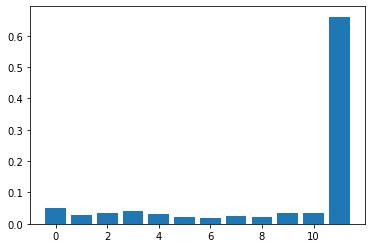

Before smote:  3422
Counter({1: 2651, 0: 771})
Counter({1: 2651, 0: 2651})
After smote :  5302
Original dataset shape Counter({1: 2651, 0: 2651})
Resampled dataset shape Counter({0: 2651, 1: 1861})
Purity
0    2651
1    1861
dtype: int64


,new_date,% Silica Feed,Amina Flow,Flotation Column 01 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 02 Level,Flotation Column 03 Level,% Iron Concentrate,% Silica Concentrate,Purity
0,20170310180000,17.16,525.485894,249.713067,250.063072,295.096000,549.616767,549.614561,66.21,3.57,0
1,20170311030000,8.25,331.547060,249.555854,249.593788,295.096000,552.302199,550.595146,65.12,4.14,0
2,20170311040000,8.25,319.234130,250.036586,250.042059,295.096000,549.753047,550.000929,64.26,3.34,0
3,20170311050000,8.25,330.744316,249.910807,249.956708,295.096000,549.746129,550.522895,64.08,4.08,0
4,20170311070000,8.98,363.725733,249.986304,250.116259,295.096000,561.392236,557.172677,63.33,4.96,0
...,...,...,...,...,...,...,...,...,...,...,...
4507,20170909190000,23.20,498.785884,301.432594,299.756449,299.929000,497.870623,409.189681,65.05,1.65,1
4508,20170909200000,23.20,510.780566,300.181000,299.593867,299.526313,498.402434,392.437663,64.83,1.71,1
4509,20170909210000,23.20,519.289535,299.419465,299.995958,299.767268,500.891915,459.091225,64.29,1.80,1
4510,20170909220000,23.20,493.451375,299.738536,299.809750,299.995732,494.662857,830.694840,64.25,1.96,1


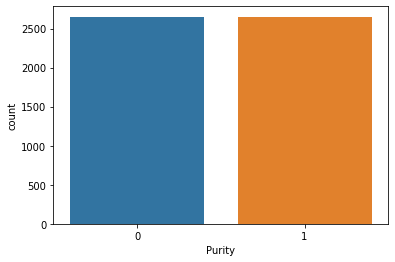

In [56]:
df_one = org

features, ranking = feature_ranking_rfe(df_one)

df_one = org[['new_date','% Silica Feed', 'Amina Flow', 'Flotation Column 01 Air Flow', 
                 'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow', 
                 'Flotation Column 02 Level', 'Flotation Column 03 Level', '% Iron Concentrate',
                 '% Silica Concentrate', 'Purity']]

smote_df_one = smote(df_one)
result_df_one = enn(smote_df_one)
result_df_one


## Data balancing ->  feature selection:

Before smote:  3422
Counter({1: 2651, 0: 771})
Counter({1: 2651, 0: 2651})
After smote :  5302
Original dataset shape Counter({1: 2651, 0: 2651})
Resampled dataset shape Counter({0: 2651, 1: 1559})
Purity
0    2651
1    1559
dtype: int64
Feature: 0, Score: 0.05276
Feature: 1, Score: 0.02890
Feature: 2, Score: 0.02070
Feature: 3, Score: 0.00886
Feature: 4, Score: 0.03230
Feature: 5, Score: 0.01941
Feature: 6, Score: 0.01388
Feature: 7, Score: 0.04722
Feature: 8, Score: 0.01826
Feature: 9, Score: 0.01231
Feature: 10, Score: 0.01736
Feature: 11, Score: 0.01816
Feature: 12, Score: 0.01056
Feature: 13, Score: 0.01290
Feature: 14, Score: 0.01396
Feature: 15, Score: 0.02927
Feature: 16, Score: 0.02992
Feature: 17, Score: 0.02285
Feature: 18, Score: 0.01267
Feature: 19, Score: 0.01359
Feature: 20, Score: 0.01228
Feature: 21, Score: 0.55186


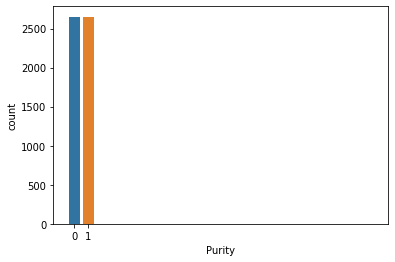

In [57]:
df_two = org

smote_df_two = smote(df_two)
smote_enn_df_two = enn(smote_df_two)
smote_enn_df_two

features, ranking = feature_ranking_rfe(smote_enn_df_two)

result_df_two = smote_enn_df_two[['new_date', '% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow', 'Ore Pulp Flow',
              'Ore Pulp pH', 'Ore Pulp Density', 'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
              'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow', 'Flotation Column 05 Air Flow', 
              'Flotation Column 06 Air Flow', 'Flotation Column 07 Air Flow', 'Flotation Column 01 Level', 
              'Flotation Column 02 Level', 'Flotation Column 03 Level', 'Flotation Column 04 Level', 'Flotation Column 05 Level',
              'Flotation Column 06 Level', 'Flotation Column 07 Level', '% Iron Concentrate',
               '% Silica Concentrate', 'Purity']]

In [58]:
all_dfs = [org, result_df_one, result_df_two]

**KNN classification**

Purity
0     771
1    2651
dtype: int64
Accuracy:  1 95.44392523364486
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       204
           1       0.96      0.99      0.97       652

    accuracy                           0.95       856
   macro avg       0.95      0.92      0.93       856
weighted avg       0.95      0.95      0.95       856

ROC_AUC_SCORE  0.9794523637675929
_______________________________________________ 

Purity
0    2651
1    1861
dtype: int64
Accuracy:  2 98.75886524822694
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       681
           1       0.99      0.98      0.98       447

    accuracy                           0.99      1128
   macro avg       0.99      0.99      0.99      1128
weighted avg       0.99      0.99      0.99      1128

ROC_AUC_SCORE  0.988664846734799
_______________________________________________ 

Purity
0    2651
1    1559
dtype: int

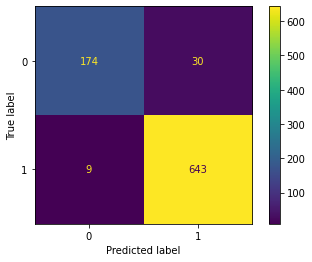

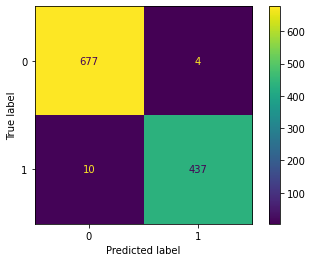

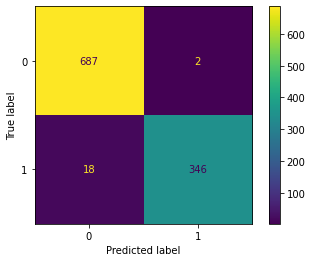

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#initialisation
model = 0
i = 0

for df in all_dfs:
  print(df.groupby(['Purity']).size())
  i = i + 1
  X = df.drop(['Purity'], axis=1)
  y = df['Purity']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  mms = MinMaxScaler()
  X_train = mms.fit_transform(X_train)
  X_test = mms.transform(X_test)

  grid_params = {
      'n_neighbors' : [3,5,11,19], # Always odd numbers to avaid ties
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }

  grid = GridSearchCV(
      KNeighborsClassifier(),
      grid_params,
      cv = 5,
      n_jobs = -1 #use all resources
  )

  grid_results = grid.fit(X_train, y_train)
  best_params = [grid_results.best_params_['metric'],grid_results.best_params_['n_neighbors'],grid_results.best_params_['weights']]

  #KNN with the best params
  model = KNeighborsClassifier(n_neighbors=best_params[1], 
                            weights=best_params[2], 
                            metric=best_params[0], 
                            n_jobs=-1)
  model.fit(X_train, y_train)
  y_test_hat=model.predict(X_test) 
  test_accuracy=accuracy_score(y_test,y_test_hat)*100


  print('Accuracy: ',i,test_accuracy)
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);  
  y_pred = model.predict(X_test)

  print(classification_report(y_test,y_pred))

  y_pred_proba = model.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  print('ROC_AUC_SCORE ',roc_auc_score(y_test,y_pred_proba))
  print('_______________________________________________ \n')


## Verdict
Feature selection and then data balacing has returned the best accuracy and roc_auc score ✅

In [60]:
result_df_one.insert(0,'dates',pd.to_datetime(result_df_one['new_date'], format='%Y%m%d%H%M%S%f'))

result_df_one = result_df_one.sort_values(by="dates")
result_df_one.drop('new_date', axis=1, inplace=True)

In [61]:
result_df_one.to_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final_dataset.csv', index=False)

In [62]:
result_df_one = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final_dataset.csv')
result_df_one

,dates,% Silica Feed,Amina Flow,Flotation Column 01 Air Flow,Flotation Column 03 Air Flow,Flotation Column 04 Air Flow,Flotation Column 02 Level,Flotation Column 03 Level,% Iron Concentrate,% Silica Concentrate,Purity
0,2017-03-10 01:00:00.000,16.98,578.910104,251.177960,250.175988,295.096000,446.972364,450.622040,66.91,1.31,1
1,2017-03-10 02:00:00.000,16.98,537.219661,249.880589,250.033317,295.096000,450.249356,450.081222,67.06,1.11,1
2,2017-03-10 03:00:00.000,16.98,591.906744,250.161328,250.046350,295.096000,450.868711,450.901822,66.97,1.27,1
3,2017-03-10 04:00:00.000,16.98,593.170106,250.208772,250.120861,295.096000,491.462111,487.387206,66.75,1.36,1
4,2017-03-10 05:00:00.000,16.98,619.710806,249.917800,250.013500,295.096000,549.983156,549.459572,66.63,1.34,1
...,...,...,...,...,...,...,...,...,...,...,...
4507,2017-09-09 19:00:00.000,23.20,498.785884,301.432594,299.756449,299.929000,497.870623,409.189681,65.05,1.65,1
4508,2017-09-09 20:00:00.000,23.20,510.780566,300.181000,299.593867,299.526313,498.402434,392.437663,64.83,1.71,1
4509,2017-09-09 21:00:00.000,23.20,519.289535,299.419465,299.995958,299.767268,500.891915,459.091225,64.29,1.80,1
4510,2017-09-09 22:00:00.000,23.20,493.451375,299.738536,299.809750,299.995732,494.662857,830.694840,64.25,1.96,1
